In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [2]:
X, y = make_blobs(n_samples=500, centers=3, n_features=2, random_state=42)

In [3]:
def has_mean(new_mean, means, tol):
    for idx, mean in enumerate(means):
        if np.allclose(new_mean, mean, atol=tol):
            return idx

def update_weighted_mean(X, x_weighted, bandwidth):
    diff = x_weighted - X
    diff_square = diff*diff
    diff_square_sum = np.sum(diff_square, axis=1)
    G = np.exp(-diff_square_sum/(2*np.square(bandwidth)))
    
    numerator = X.T.dot(G)
    denominator = np.sum(G)
    return numerator/denominator

In [4]:
def meanshift(X, bandwidth, max_iter, tol, need_track, track_point_idx):
    it = 0
    means = None
    labels = []
    means_track = []
        
    for idx, x in enumerate(X):
        x_weighted = x
        while it < max_iter:
            x_weighted_new = update_weighted_mean(X, x_weighted, bandwidth)
            # stop iteration if converged
            if np.allclose(x_weighted, x_weighted_new):
                break
            else:
                x_weighted = x_weighted_new
            # only track the particular data point
            if need_track and idx == track_point_idx:
                means_track.append(x_weighted)
            it += 1
        if it == max_iter:
            print('case', idx, 'did not converged')
        if idx == 0:
            means = np.array([x_weighted])
            label = idx
        else:
            mean_idx = has_mean(x_weighted, means, tol)
            if mean_idx is None:
                means = np.vstack((means, x_weighted))
                label += 1
            else:
                label = mean_idx
        labels.append(label)
    return means, np.array(labels), np.array(means_track)

In [5]:
from sklearn.cluster import estimate_bandwidth
bandwidth = estimate_bandwidth(X)

In [6]:
means, labels, means_track = meanshift(X, bandwidth, 10000, 1e-03, True, 0)

In [7]:
from sklearn.cluster import MeanShift
sk_ms = MeanShift().fit(X)

In [8]:
def plot_scatter(ax, X, labels, centroids, title):
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='cividis')
    for centroid in centroids:
        ax.scatter(centroid[0], centroid[1], c='red')
    ax.set_title(title)

In [9]:
def plot_track(ax, X_sub, means_track):
    start_point = X_sub[0]
    end_point= means_track[-1]
    dx = end_point[0] - start_point[0]
    dy = end_point[1] - start_point[1]
    ax.arrow(start_point[0], start_point[1], dx, dy,
             alpha=0.5, head_width=0.5, width=0.1, color='red', zorder=10)

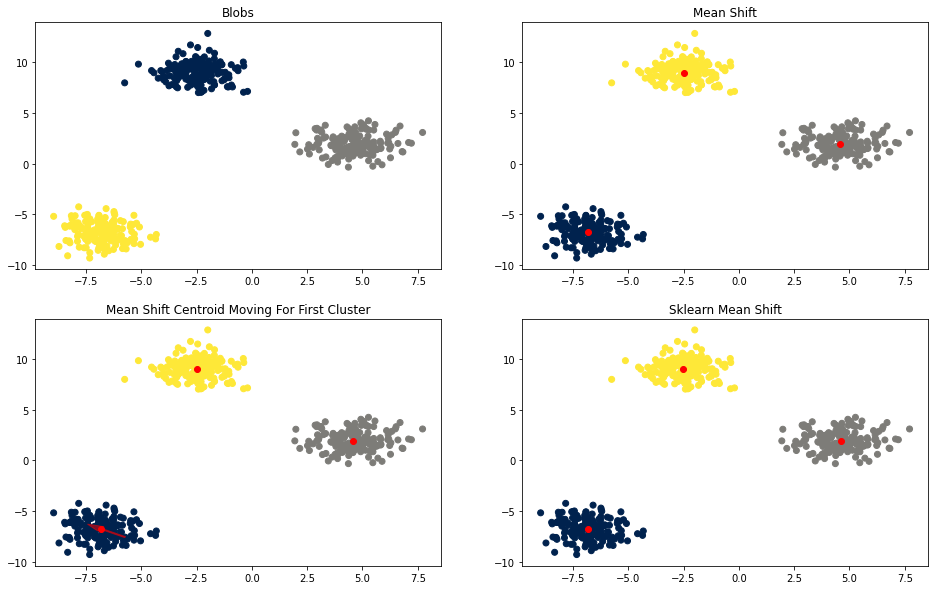

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plot_scatter(axes[0, 0], X, y, [], 'Blobs')
plot_scatter(axes[0, 1], X, labels, means, 'Mean Shift')
plot_scatter(axes[1, 0], X, labels, means, 'Mean Shift Centroid Moving For First Cluster')
plot_scatter(axes[1, 1], X, sk_ms.labels_, sk_ms.cluster_centers_, 'Sklearn Mean Shift')

plot_track(axes[1, 0], X[labels==0], means_track)